In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.swa_utils import AveragedModel
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [15]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

train_images = []
train_labels = []
data_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
for batch in data_batches:
    # Load one batch for demonstration (e.g., data_batch_1)
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, batch))
    train_images.append(batch_dict[b'data'])
    train_labels.append(batch_dict[b'labels'])

train_images = np.concatenate((train_images[0], train_images[1], train_images[2], train_images[3], train_images[4]))
train_labels = np.concatenate((train_labels[0], train_labels[1], train_labels[2], train_labels[3], train_labels[4]))

# Reshape the images
train_images = train_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images 
test_images = cifar10_batch[b'data'].astype(np.float32) / 255.0


validation_data = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch')

validation_images = validation_data[b'data']
validation_labels = validation_data[b'labels']

validation_images = validation_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomResizedCrop(32, scale=(0.6, 1.0)),  # First, random cropping to increase variation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Small perspective changes
    transforms.RandomRotation(10),  # Small rotations for robustness
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip is common for CIFAR-10
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Small color changes
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),  # Not crucial but can keep
    transforms.ToTensor(),  # Convert to tensor (0-1 range)
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize last
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize last
])

class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if(self.labels is not None):
            label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        if(self.labels is not None):
            return img, label
        else:
            return img

train_dataset = CustomCIFAR10Dataset(train_images, train_labels, transform=train_transform)
validation_dataset = CustomCIFAR10Dataset(validation_images, validation_labels, transform=test_transform)
test_dataset = CustomCIFAR10Dataset(test_images, transform=test_transform)

trainDataLoader = torch.utils.data.DataLoader(train_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=True)

validationDataLoader = torch.utils.data.DataLoader(validation_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=False)

testDataLoader = torch.utils.data.DataLoader(test_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=False)

In [5]:
data_iter = iter(trainDataLoader)
images, labels = next(data_iter)

# Print the shape and type of the images and labels
print("Shape of images:", images.shape)  # e.g., torch.Size([64, 3, 32, 32])
print("Type of images:", type(images))  # <class 'torch.Tensor'>

print("Shape of labels:", labels.shape)  # e.g., torch.Size([64])
print("Type of labels:", type(labels))  # <class 'torch.Tensor'>

Shape of images: torch.Size([256, 3, 32, 32])
Type of images: <class 'torch.Tensor'>
Shape of labels: torch.Size([256])
Type of labels: <class 'torch.Tensor'>


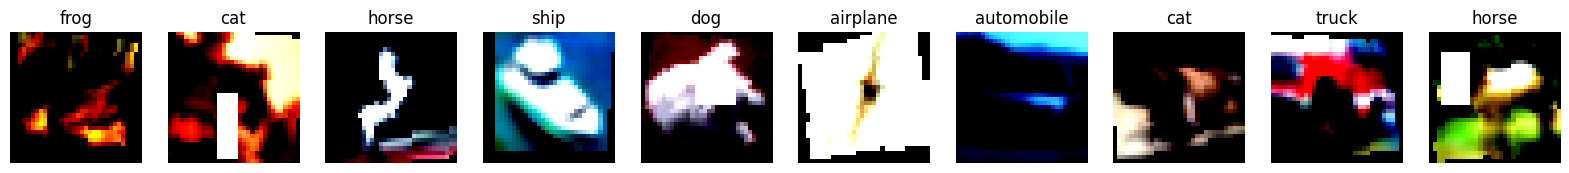

In [16]:
data_iter = iter(trainDataLoader)
images, labels = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.title(label_names[labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

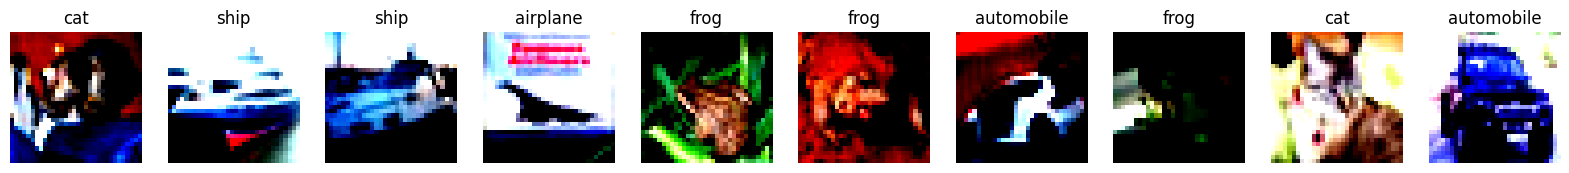

In [7]:
data_iter = iter(validationDataLoader)
images, labels = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.title(label_names[labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

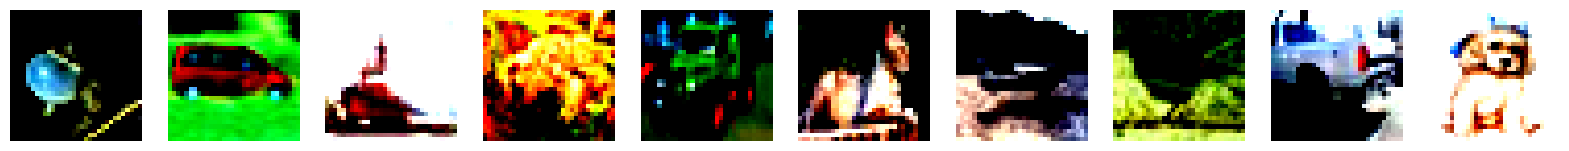

In [17]:
data_iter = iter(testDataLoader)
images = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [18]:
class BuildingBlock(nn.Module):

    
    def __init__(self, in_planes, planes, stride=1):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU()

        self.skip = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)  
        out += self.skip(x) 
        out = self.relu2(out)
        return out


class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(256, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes  # Update input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(BuildingBlock, [4, 4, 3])
model = AveragedModel(model)
model = model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
     BuildingBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [25]:
from tqdm import tqdm

loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 80, 90], gamma=0.1)

train_loss_history = []
val_loss_history = []
train_accuracies = []
val_accuracies = []

num_epochs = 30

for epoch in tqdm(range(num_epochs)):
  train_loss = 0.0
  val_loss = 0.0

  correct = 0
  total = 0
  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    predicted = torch.argmax(predicted_output, dim=1)
    correct += (predicted == labels).sum().item()  # Count correct predictions
    total += labels.size(0)  # Total number of samples
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  train_accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Train Accuracy: {train_accuracy:.2f}%')

  correct = 0
  total = 0
  model.eval()
  for i, data in enumerate(validationDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      predicted_output = model(images)
      predicted = torch.argmax(predicted_output, dim=1)
      correct += (predicted == labels).sum().item()  # Count correct predictions
      total += labels.size(0)  # Total number of samples
      fit = loss(predicted_output, labels)
      val_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  val_loss = val_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  val_loss_history += [val_loss]
  val_accuracy = 100 * correct / total  # Compute accuracy percentage
  train_accuracies += [train_accuracy]
  val_accuracies += [val_accuracy]
  print(f'Val Accuracy: {val_accuracy:.2f}%')
  print(f'Epoch {epoch}, Train loss {train_loss}, val loss {val_loss}')

  scheduler.step(val_accuracy)

  0%|          | 0/30 [00:00<?, ?it/s]

Train Accuracy: 91.72%


  3%|▎         | 1/30 [00:58<28:20, 58.65s/it]

Val Accuracy: 88.26%
Epoch 0, Train loss 0.2360530084341156, val loss 0.36764541193842887
Train Accuracy: 91.74%


  7%|▋         | 2/30 [02:04<29:24, 63.01s/it]

Val Accuracy: 89.30%
Epoch 1, Train loss 0.2352648875390997, val loss 0.34003046378493307
Train Accuracy: 91.58%


 10%|█         | 3/30 [03:12<29:14, 64.97s/it]

Val Accuracy: 88.61%
Epoch 2, Train loss 0.2416902162058621, val loss 0.35047738440334797
Train Accuracy: 91.72%


 13%|█▎        | 4/30 [04:19<28:34, 65.96s/it]

Val Accuracy: 87.12%
Epoch 3, Train loss 0.23622756215686702, val loss 0.39022217374295
Train Accuracy: 91.74%


 17%|█▋        | 5/30 [05:27<27:45, 66.61s/it]

Val Accuracy: 88.31%
Epoch 4, Train loss 0.23534023609696603, val loss 0.35983760803937914
Train Accuracy: 91.70%


 20%|██        | 6/30 [06:34<26:42, 66.75s/it]

Val Accuracy: 87.86%
Epoch 5, Train loss 0.23767840178037175, val loss 0.37262806072831156
Train Accuracy: 91.61%


 23%|██▎       | 7/30 [07:41<25:42, 67.05s/it]

Val Accuracy: 88.94%
Epoch 6, Train loss 0.23923142056684105, val loss 0.3364092245697975
Train Accuracy: 92.10%


 27%|██▋       | 8/30 [08:48<24:34, 67.03s/it]

Val Accuracy: 90.08%
Epoch 7, Train loss 0.22602083891326066, val loss 0.3172004986554384
Train Accuracy: 91.90%


 30%|███       | 9/30 [09:55<23:25, 66.93s/it]

Val Accuracy: 89.33%
Epoch 8, Train loss 0.2291508916841478, val loss 0.3400392673909664
Train Accuracy: 91.92%


 33%|███▎      | 10/30 [11:03<22:21, 67.07s/it]

Val Accuracy: 89.22%
Epoch 9, Train loss 0.2302810556578393, val loss 0.32426969781517984
Train Accuracy: 92.37%


 37%|███▋      | 11/30 [12:10<21:17, 67.26s/it]

Val Accuracy: 89.35%
Epoch 10, Train loss 0.21736734269224867, val loss 0.35057624280452726
Train Accuracy: 92.27%


 40%|████      | 12/30 [13:17<20:10, 67.24s/it]

Val Accuracy: 88.74%
Epoch 11, Train loss 0.22043647077314707, val loss 0.3624240143224597
Train Accuracy: 92.25%


 43%|████▎     | 13/30 [14:25<19:05, 67.36s/it]

Val Accuracy: 88.56%
Epoch 12, Train loss 0.22094329241283087, val loss 0.3526774004101753
Train Accuracy: 92.33%


 47%|████▋     | 14/30 [15:32<17:55, 67.20s/it]

Val Accuracy: 88.87%
Epoch 13, Train loss 0.21957596265995988, val loss 0.3372019618749619
Train Accuracy: 95.02%


 50%|█████     | 15/30 [16:38<16:45, 67.01s/it]

Val Accuracy: 92.46%
Epoch 14, Train loss 0.14463769587479075, val loss 0.2253621280193329
Train Accuracy: 96.33%


 53%|█████▎    | 16/30 [17:46<15:38, 67.06s/it]

Val Accuracy: 92.83%
Epoch 15, Train loss 0.11147048307240617, val loss 0.21840775646269323
Train Accuracy: 96.62%


 57%|█████▋    | 17/30 [18:53<14:32, 67.12s/it]

Val Accuracy: 92.97%
Epoch 16, Train loss 0.10162934191448957, val loss 0.22053380087018012
Train Accuracy: 96.72%


 60%|██████    | 18/30 [20:00<13:25, 67.12s/it]

Val Accuracy: 92.51%
Epoch 17, Train loss 0.09674789313683096, val loss 0.2242438241839409
Train Accuracy: 97.01%


 63%|██████▎   | 19/30 [21:07<12:19, 67.20s/it]

Val Accuracy: 93.05%
Epoch 18, Train loss 0.08998561874792284, val loss 0.21769179366528987
Train Accuracy: 97.06%


 67%|██████▋   | 20/30 [22:15<11:13, 67.37s/it]

Val Accuracy: 92.95%
Epoch 19, Train loss 0.08770339840985074, val loss 0.22571067716926335
Train Accuracy: 97.32%


 70%|███████   | 21/30 [23:22<10:06, 67.35s/it]

Val Accuracy: 92.75%
Epoch 20, Train loss 0.08054031460184832, val loss 0.22597010917961596
Train Accuracy: 97.41%


 73%|███████▎  | 22/30 [24:30<08:59, 67.50s/it]

Val Accuracy: 92.91%
Epoch 21, Train loss 0.07756638180046362, val loss 0.2338312342762947
Train Accuracy: 97.44%


 77%|███████▋  | 23/30 [25:38<07:52, 67.55s/it]

Val Accuracy: 93.05%
Epoch 22, Train loss 0.07597924981798444, val loss 0.23135772421956063
Train Accuracy: 97.57%


 80%|████████  | 24/30 [26:46<06:45, 67.59s/it]

Val Accuracy: 93.23%
Epoch 23, Train loss 0.07081044057612212, val loss 0.22649776339530944
Train Accuracy: 97.70%


 83%|████████▎ | 25/30 [27:53<05:37, 67.43s/it]

Val Accuracy: 92.64%
Epoch 24, Train loss 0.0680808696933851, val loss 0.23455299623310566
Train Accuracy: 97.84%


 87%|████████▋ | 26/30 [29:00<04:29, 67.44s/it]

Val Accuracy: 92.69%
Epoch 25, Train loss 0.06432149999261814, val loss 0.24232964348047972
Train Accuracy: 97.70%


 90%|█████████ | 27/30 [30:07<03:22, 67.34s/it]

Val Accuracy: 92.77%
Epoch 26, Train loss 0.06869346050697626, val loss 0.23433302342891693
Train Accuracy: 97.89%


 93%|█████████▎| 28/30 [31:15<02:15, 67.51s/it]

Val Accuracy: 92.85%
Epoch 27, Train loss 0.062343448077385524, val loss 0.2444227185100317
Train Accuracy: 97.91%


 97%|█████████▋| 29/30 [32:23<01:07, 67.49s/it]

Val Accuracy: 92.95%
Epoch 28, Train loss 0.06299968814591364, val loss 0.24343310594558715
Train Accuracy: 97.84%


100%|██████████| 30/30 [33:29<00:00, 66.99s/it]

Val Accuracy: 92.94%
Epoch 29, Train loss 0.06242027635477027, val loss 0.24280067570507527


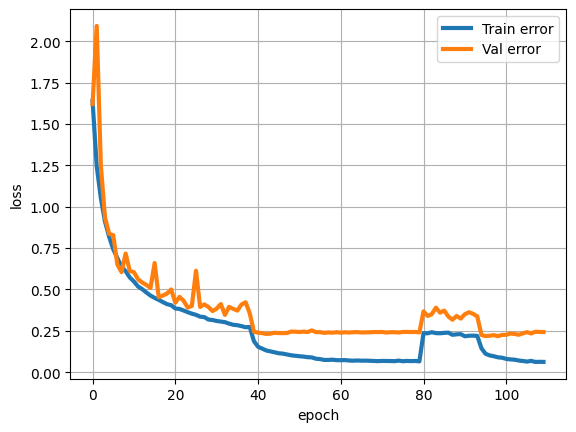

In [27]:
# Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss', color='red')
    plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss & Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Accuracy & Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [28]:
model.eval()
predictions = []
with torch.no_grad():
    for images in testDataLoader:
        images = images.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved.")

Submission file saved.


In [23]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    images = torch.tensor(test_images[i], dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
    images = images.permute(2, 0, 1).unsqueeze(0).to(device)  # Add batch dimension and move to device
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1).item()  # Extract the prediction
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[i])  # Original image format for visualization
    plt.title(label_names[predicted].decode('utf-8'))  # Show predicted label as title
    plt.axis('off')

plt.show()